# Load data

In [9]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

SAMPLE_DIR = DATA_DIR / "samples"

TRAIN_DIR = DATA_DIR / "train"
NORMAL_DIR = TRAIN_DIR / "normal"
SPOOF_DIR = TRAIN_DIR / "spoof"

DEV_DIR = DATA_DIR / "dev"
DEV_NORMAL_DIR = DEV_DIR / "normal"
DEV_SPOOF_DIR = DEV_DIR / "spoof"

TEST_DIR = DATA_DIR / "test"
TEST_NORMAL_DIR = TEST_DIR / "normal"
TEST_SPOOF_DIR = TEST_DIR / "spoof"

In [17]:
import sys

# PROJECT_ROOT của bạn đang là: .../cake-bank-classifier-project
# Chúng ta cần thêm đường dẫn này vào danh sách tìm kiếm của Python
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

(-0.5, 1079.5, 1919.5, -0.5)

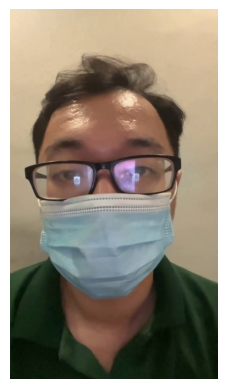

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = list(NORMAL_DIR.glob("*.jpg"))[5]
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


In [19]:
normal_samples = list(NORMAL_DIR.glob("*.jpg"))
spoof_samples = list(SPOOF_DIR.glob("*.jpg"))
len(normal_samples), len(spoof_samples)

(1432, 1368)

In [20]:
dev_normal_samples = list(DEV_NORMAL_DIR.glob("*.jpg"))
dev_spoof_samples = list(DEV_SPOOF_DIR.glob("*.jpg"))
len(dev_normal_samples), len(dev_spoof_samples)

(551, 524)

In [21]:
for img_path in NORMAL_DIR.glob("*.jpg"):
  img = Image.open(img_path)
  if img.size[0] < 448 or img.size[1] <= 448:
    print(f"{img_path}: {img.size}")

E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1139_1.jpg: (320, 576)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1139_2.jpg: (320, 576)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1139_3.jpg: (320, 576)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1139_4.jpg: (320, 576)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1345_1.jpg: (416, 852)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1345_2.jpg: (416, 852)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1345_3.jpg: (416, 852)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1345_4.jpg: (416, 852)
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal\1366_1.jpg: (32

# Preprocessing

In [22]:
import os
from pathlib import Path


for folder in TRAIN_DIR.iterdir():
  print(folder)
  print(folder.name)

os.listdir(TRAIN_DIR)

E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\normal
normal
E:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\data\raw\train\spoof
spoof


['normal', 'spoof']

In [35]:
from src.classifier.data_module.dataloader import LivenessDataLoader
# from config import TRAIN_DIR, DEV_DIR, TEST_DIR, SAMPLE_DIR # Giả sử bạn có file config

load_provider = LivenessDataLoader(
    train_path=TRAIN_DIR,
    dev_path=DEV_DIR,
    test_path=TEST_DIR,
    samples_path=SAMPLE_DIR,
    batch_size=32
)

# 1. Setup Data
load_provider.setup('fit')

# 2. Get Loaders
train_loader = load_provider.get_train_loader()
dev_loader = load_provider.get_dev_loader()
# 3. Check thử augmentation
# Lấy 1 batch từ train xem nó có bị méo mó/đổi màu (augmentation) không
images, labels = next(iter(train_loader))
print(f"Train Batch Shape: {images.shape}") # Expect: [32, 3, 224, 224]

Train Batch Shape: torch.Size([32, 3, 224, 224])


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LivenessCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # (B,128,1,1)
        )

        self.classifier = nn.Linear(128, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)        # (B,128)
        logits = self.classifier(x)
        return logits


In [25]:
from torchvision import models

class LivenessDetectionModel(nn.Module):

    def __init__(self, num_classes=2, pretrained=True, dropout=0.35):
        super().__init__()


        # Load EfficientNet-B2 (larger model, better for recall)
        self.backbone = models.efficientnet_b2(pretrained=False)
        num_features = self.backbone.classifier[1].in_features  # 1408 for B2
        self.backbone.classifier = nn.Identity()

        # Enhanced classifier head for better discrimination
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 768),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(768),
            nn.Dropout(p=dropout + 0.05),
            nn.Linear(768, 384),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(384),
            nn.Dropout(p=dropout),
            nn.Linear(384, num_classes)
        )

        # Load pretrained weights manually if requested
        if pretrained:
            try:
                import torch.utils.model_zoo as model_zoo
                state_dict = model_zoo.load_url(
                    'https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth',
                    map_location='cpu',
                    check_hash=False  # Skip hash validation
                )
                # Load only backbone weights (not classifier)
                backbone_state = {k.replace('module.', ''): v for k, v in state_dict.items()
                                    if not k.startswith('classifier')}
                self.backbone.load_state_dict(backbone_state, strict=False)
                print("✓ Loaded EfficientNet-B2 pretrained weights")
            except Exception as e:
                print(f"⚠ Warning: Could not load pretrained weights: {e}")
                print("  Continuing with random initialization...")
        

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

In [26]:
from tqdm.auto import tqdm
from classifier.evaluations import compute_metrics

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
        
    pbar = tqdm(loader, desc="Train", leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.long().to(device)
        
        optimizer.zero_grad()
        logits = model(images)
            
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader)


e:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from typing import Literal

@torch.no_grad()
def evaluate(model, stage: Literal["Test", "Val"], loader, criterion, device):
    model.eval()
    total_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    pbar = tqdm(loader, desc=stage, leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.long().to(device)

        logits = model(images)          # (B, 2)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        probs = torch.softmax(logits, dim=1)   # (B, 2)
        preds = torch.argmax(probs, dim=1)     # (B,)

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs[:, 1].cpu())    # prob of class 1

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()

    metrics = compute_metrics(y_true, y_pred, y_prob)
    return total_loss / len(loader), metrics


In [30]:
import torch.nn as nn
from classifier.regularizations import EarlyStopping
import mlflow

NUM_EPOCHS = 10
ETA_MIN = 1e-4
mlflow.set_experiment("Liveness Baseline")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model = LivenessCNN().to(device)
model = LivenessDetectionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=ETA_MIN)
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)


with mlflow.start_run():
    mlflow.log_params({"learning_rate": 1e-3, "batch_size": 32, "epochs": NUM_EPOCHS})
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            device
        )

        val_loss, val_metrics = evaluate(
            model,
            "Val",
            dev_loader,
            criterion,
            device
        )
        
        scheduler.step()
        early_stopping(val_loss, model)

        if early_stopping(val_loss, model):
            break
        
        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_metrics["accuracy"],
            "val_precision": val_metrics["precision"],
            "val_recall": val_metrics["recall"],
            "val_roc_auc": val_metrics["roc_auc"],
            "val_avg_precision": val_metrics["avg_precision"],
            "val_f1_score": val_metrics["f1_score"]
        })
        
        print(
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f}"
        )
    mlflow.pytorch.log_model(model, name="model") 


e:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\My Document\Data_Engineer_Projects\cake-bank-classifier-project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Loaded EfficientNet-B2 pretrained weights

Epoch 1/10


EarlyStopping counter: 1 out of 5
Train Loss: 0.3667 | Val Loss: 0.2966 | Val Acc: 0.9042

Epoch 2/10


EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Train Loss: 0.1449 | Val Loss: 0.3074 | Val Acc: 0.9014

Epoch 3/10


EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Train Loss: 0.1024 | Val Loss: 0.5687 | Val Acc: 0.7786

Epoch 4/10


EarlyStopping counter: 6 out of 5
EarlyStopping counter: 7 out of 5
Train Loss: 0.0938 | Val Loss: 0.3764 | Val Acc: 0.8902

Epoch 5/10


EarlyStopping counter: 8 out of 5
EarlyStopping counter: 9 out of 5
Train Loss: 0.0929 | Val Loss: 0.3867 | Val Acc: 0.8809

Epoch 6/10


EarlyStopping counter: 10 out of 5
EarlyStopping counter: 11 out of 5
Train Loss: 0.0729 | Val Loss: 0.3199 | Val Acc: 0.9042

Epoch 7/10


EarlyStopping counter: 12 out of 5
EarlyStopping counter: 13 out of 5
Train Loss: 0.0417 | Val Loss: 0.5780 | Val Acc: 0.8419

Epoch 8/10


EarlyStopping counter: 14 out of 5
EarlyStopping counter: 15 out of 5
Train Loss: 0.0445 | Val Loss: 0.3321 | Val Acc: 0.9265

Epoch 9/10


EarlyStopping counter: 16 out of 5
EarlyStopping counter: 17 out of 5
Train Loss: 0.0247 | Val Loss: 0.3183 | Val Acc: 0.9144

Epoch 10/10


EarlyStopping counter: 18 out of 5
EarlyStopping counter: 19 out of 5
Train Loss: 0.0148 | Val Loss: 0.3533 | Val Acc: 0.9014


2025/12/29 11:24:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/29 11:24:07 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/29 11:24:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [32]:
load_provider.setup('test')

test_loader = load_provider.get_test_loader()

In [33]:
test_loss, test_metrics = evaluate(
            model,
            "Test",
            test_loader,
            criterion,
            device
        )


In [34]:
from pprint import pprint

pprint(f"Test Loss: {test_loss:.4f} | \n"
f"Test Acc: {test_metrics}")

('Test Loss: 0.2425 | \n'
 "Test Acc: {'accuracy': 0.9241452991452992, 'precision': 0.8857715430861723, "
 "'recall': 0.9692982456140351, 'roc_auc': 0.9778097587719298, "
 "'avg_precision': 0.9780567112372031, 'f1_score': 0.9256544502617801}")
